In [5]:
!pip install tensorflow 

Keyring is skipped due to an exception: 'keyring.backends'
  Using cached tensorflow-2.11.0-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (588.3 MB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached keras-2.11.0-py2.py3-none-any.whl (1.7 MB)
  Using cached tensorboard-2.11.2-py3-none-any.whl (6.0 MB)
  Using cached libclang-18.1.1-py2.py3-none-manylinux2010_x86_64.whl (24.5 MB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached termcolor-2.3.0-py3-none-any.whl (6.9 kB)
  Using cached tensorboard_data_server-0.6.1-py3-none-manylinux2010_x86_64.whl (4.9 MB)
  Using cached Werkzeug-2.2.3-py3-none-any.whl (233 kB)
  Attempting uninstall: werkzeug
    Found existing installation: Werkzeug 1.0.0
    Uninstalling Werkzeug-1.0.0:
      Successfully uninstalled Werkzeug-1.0.0


In [6]:

import os
import shutil
import zipfile
import tensorflow as tf

In [7]:
# Function to rename files in a folder
def rename_files(folder_path, label):
    # List all files in the folder
    files = os.listdir(folder_path)

    # Filter to include only .gif files
    gif_files = [f for f in files if f.endswith('.gif')]

    # Rename each file
    for index, filename in enumerate(gif_files):
        # Construct new file name
        new_name = f"{label}_{index + 1}.gif"

        # Get full path for the old and new file names
        old_file = os.path.join(folder_path, filename)
        new_file = os.path.join(folder_path, new_name)

        # Rename the file
        os.rename(old_file, new_file)
    print(f"Renamed files in {folder_path} to {label}_#.gif")

In [8]:
# Extract the zip file
zip_file_path = '/dgxa_home/se20ucse004/gif_data.zip'
extracted_folder = 'gif_data_extracted.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder)

In [9]:
# Paths to the extracted folders
sad_folder = os.path.join(extracted_folder, 'Sad_2')
happy_folder = os.path.join(extracted_folder, 'Happy_3')

In [10]:
# Rename the files in each folder
rename_files(sad_folder, 'sad')
rename_files(happy_folder, 'happy')

Renamed files in gif_data_extracted.zip/Sad_2 to sad_#.gif
Renamed files in gif_data_extracted.zip/Happy_3 to happy_#.gif


In [11]:
# Load and preprocess data without data augmentation
def load_data(data_dir, image_size, batch_size, validation_split=0.35):
    # Load and preprocess training data with validation split
    train_data = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        labels='inferred',
        label_mode='categorical',
        color_mode='rgb',
        batch_size=batch_size,
        image_size=image_size,
        validation_split=validation_split,
        subset='training',
        seed=123
    )

    # Load and preprocess validation data with validation split
    val_data = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        labels='inferred',
        label_mode='categorical',
        color_mode='rgb',
        batch_size=batch_size,
        image_size=image_size,
        validation_split=validation_split,
        subset='validation',
        seed=123
    )

    return train_data, val_data

In [12]:
# Set parameters (gloabl for all algo)
data_dir = '/dgxa_home/se20ucse004/gif_data_extracted.zip'
image_size = (224, 224)
batch_size = 32
num_classes = 2

In [13]:
# Calculate class weights to handle class imbalance
def calculate_class_weights(data_dir):
    # Count the number of samples in each class
    class_counts = {}
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        class_counts[class_name] = len(os.listdir(class_path))


    # Calculate class weights
    total_samples = sum(class_counts.values())
    class_weights = {}
    for class_name, count in class_counts.items():
        class_weights[class_name] = total_samples / (len(class_counts) * count)

    return class_weights

In [14]:
# Load the data (global for all algo)
train_data, val_data = load_data(data_dir, image_size, batch_size)

Found 2354 files belonging to 2 classes.
Using 1531 files for training.
Found 2354 files belonging to 2 classes.
Using 823 files for validation.


In [15]:
calculate_class_weights(data_dir)

{'Happy_3': 0.6023541453428863, 'Sad_2': 2.9425}

Resnet +CNN

In [28]:
import os
import zipfile
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from sklearn.metrics import roc_curve, auc

In [17]:
# Load pre-trained ResNet50 model without top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))

# Add custom CNN layers on top of ResNet50
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout for regularization
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout for regularization
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout for regularization
predictions = Dense(num_classes, activation='softmax')(x)

94765736/94765736 [==============================] - 6s 0us/step


In [18]:
# Model to be trained
model_resnet_cnn = Model(inputs=base_model.input, outputs=predictions)

In [19]:
# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

In [20]:
# Compile the model
model_resnet_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
# Train the model using dgx------------------------------------------------
history = model_resnet_cnn.fit(train_data, epochs=100, validation_data=val_data)

Epoch 1/100
48/48 [==============================] - 159s 3s/step - loss: 0.7606 - accuracy: 0.7551 - val_loss: 0.4941 - val_accuracy: 0.8165
Epoch 2/100
48/48 [==============================] - 135s 3s/step - loss: 0.5279 - accuracy: 0.8125 - val_loss: 0.4902 - val_accuracy: 0.8165
Epoch 3/100
48/48 [==============================] - 149s 3s/step - loss: 0.4861 - accuracy: 0.8204 - val_loss: 0.4907 - val_accuracy: 0.8165
Epoch 4/100
48/48 [==============================] - 162s 3s/step - loss: 0.4843 - accuracy: 0.8269 - val_loss: 0.5265 - val_accuracy: 0.8165
Epoch 5/100
48/48 [==============================] - 159s 3s/step - loss: 0.4573 - accuracy: 0.8367 - val_loss: 0.4527 - val_accuracy: 0.8165
Epoch 6/100
48/48 [==============================] - 156s 3s/step - loss: 0.4421 - accuracy: 0.8328 - val_loss: 0.4609 - val_accuracy: 0.8165
Epoch 7/100
48/48 [==============================] - 139s 3s/step - loss: 0.4313 - accuracy: 0.8374 - val_loss: 0.4575 - val_accuracy: 0.8165
Epoch 

In [22]:
# Evaluate the model on the training data
print("Evaluating the model...")
train_loss, train_accuracy = model_resnet_cnn.evaluate(train_data, verbose=0)
print(f"Training loss for resnet+cnn: {train_loss}")
print(f"Training accuracy for resnet+cnn: {train_accuracy}")

# Evaluate the model on the validation data
print("Evaluating the model...")
Val_loss, val_acc = model_resnet_cnn.evaluate(val_data, verbose=0)
print(f"val loss for resnet+cnn: {Val_loss}")
print(f"val accuracy for resnet+cnn: {val_acc}")

Evaluating the model...
Training loss for resnet+cnn: 0.07364995032548904
Training accuracy for resnet+cnn: 0.9902024865150452
Evaluating the model...
val loss for resnet+cnn: 1.4569300413131714
val accuracy for resnet+cnn: 0.8104496002197266


In [23]:
y_pred = model_resnet_cnn.predict(val_data)
y_true = np.concatenate([y for x, y in val_data], axis=0)

26/26 [==============================] - 52s 2s/step


In [25]:
!pip install matplotlib
import matplotlib.pyplot as plt

Keyring is skipped due to an exception: 'keyring.backends'


In [29]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(fpr[i])
    print(tpr[i])
print(roc_auc)

[0.         0.01324503 0.33774834 0.35099338 0.36423841 0.39735099
 0.39735099 0.39735099 0.39735099 0.39735099 0.40397351 0.41059603
 0.41059603 0.41059603 0.41059603 0.41059603 0.41059603 0.42384106
 0.43046358 0.43046358 0.43046358 0.43708609 0.43708609 0.44370861
 0.45033113 0.45033113 0.45695364 0.45695364 0.46357616 0.46357616
 0.46357616 0.46357616 0.47019868 0.47019868 0.48344371 0.48344371
 0.48344371 0.48344371 0.49006623 0.49006623 0.49668874 0.49668874
 0.50331126 0.50331126 0.50993377 0.50993377 0.51655629 0.51655629
 0.52317881 0.53642384 0.53642384 0.54304636 0.54304636 0.55629139
 0.55629139 0.56291391 0.56291391 0.56953642 0.56953642 0.57615894
 0.57615894 0.58278146 0.58278146 0.58940397 0.58940397 0.59602649
 0.59602649 0.60264901 0.60264901 0.60927152 0.60927152 0.62913907
 0.62913907 0.63576159 0.63576159 0.64238411 0.64238411 0.64900662
 0.64900662 0.66225166 0.66225166 0.68211921 0.68211921 0.68874172
 0.68874172 0.69536424 0.69536424 0.70198675 0.70198675 0.7086

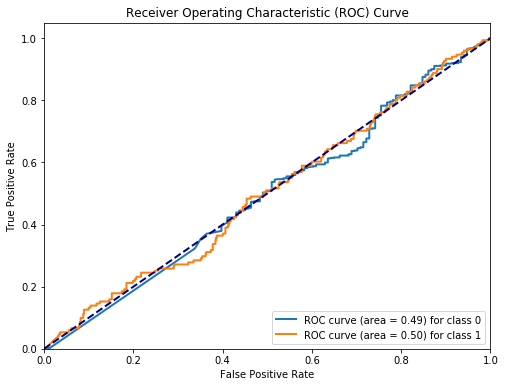

In [30]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = %0.2f) for class %d' % (roc_auc[i], i))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()